In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import itertools
import random
from scipy.stats import kstest
from tqdm import tqdm

In [2]:
def extract_data(data_path,gene_loc_path,tad_path,hivar_pctl=None,excl_chrom=['chrM','chrX','chrY']):
    """
    excl_chrom: list of strings corresponding to chromosomes to be excluded
    data_path: path to single cell tpm data
    gene_loc_path: path to file containing information on gene locations
    ===
    return a dataframe with genes as rows and samples as columns
    make sure the genes are contained in the chromosome location info file (take intersection)
    """
    # read in data
    sc_df = pd.read_csv(data_path,index_col=0)
    sc_df = sc_df.loc[[idx for idx in sc_df.index if 'ENSMUSG' in idx]]
    gloc = pd.read_csv(gene_loc_path,sep="\t",index_col=0)
    tad = pd.read_csv(tad_path)
    # index manipulation
    sc_df_idx = [idx.split(".")[0] for idx in sc_df.index]
    sc_df.index = sc_df_idx
    gloc_idx = [idx.split(".")[0] for idx in gloc.index]
    gloc.index = gloc_idx
    # get rid of genes with 0 exp across all samples
    sc_df_filtered = sc_df.loc[np.sum(sc_df,axis=1)!=0]
    # filter gene by variance across samples/tissues if thus specified
    if type(hivar_pctl)==int or type(hivar_pctl)==float:
        if hivar_pctl>=0 and hivar_pctl<=100:
            sc_df_filtered = filter_genes_by_variance(sc_df_filtered,hivar_pctl)
    # get rid of chromosomes in exclusion list
    gloc_filtered = gloc[gloc['seqname'].isin(set(gloc.seqname).difference(excl_chrom))]
    tad_filtered = tad[tad['chrom'].isin(set(gloc.seqname).difference(excl_chrom))]
    # get intersecting genes in both
    gene_list = set(sc_df_filtered.index).intersection(gloc_filtered.index)
    sc_df_filtered = sc_df_filtered.loc[gene_list]
    gloc_filtered = gloc_filtered.loc[gene_list]
    return sc_df_filtered, gloc_filtered, tad_filtered
def filter_genes_by_variance(sc_df,percentile):
    """
    filters a TPM (genes x tissue !!!!) dataset by highest percentile of variance across tissue/samples

    IMPORTANT: do not feed in normalized data. That would make this pointless.
    """
    sc_df = sc_df.T
    gene_vars = sc_df.var()
    most_var_genes = (gene_vars >= np.percentile(gene_vars,percentile))
    return sc_df.loc[:,most_var_genes].T # inverts back to genes x samples/tissues


def log2norm_tpm(tpm_data):
    """
    returns log2-normalized tpm data
    """
    return zscore(np.log2(tpm_data+1),axis=1)


def tad_gene_dict(tad_locs,gloc,filter_bar=5):
    tg_dict = dict(zip(list(range(len(tad_locs))),[[]]*len(tad_locs)))
    for i in range(len(tad_locs)):
        data = tad_locs.loc[i]
        tg_dict[i] = get_genes_in_interval(data['chrom'],data['start'],data['end'],gloc)
    if filter_bar > 0:
        tg_dict = {k:v for k,v in tg_dict.items() if len(v)>=filter_bar}
    return tg_dict
def get_genes_in_interval(chrom,start,end,gloc):
    """
    get genes in an interval on a chromosome
    """
    gloc_chr = gloc[gloc['seqname']==chrom]
    gloc_chr = gloc_chr[(gloc_chr['start'] >= start) & (gloc_chr['end'] < end)]
    return list(gloc_chr.index)

def get_genes_from_chromosome(chr_name,tpm_data,tad_data,gloc_data):
    """
    chr_name: e.g. 'chr1', the string corresponding to the chromosome you want to extract data on
    tpm_data: dataframe of tpms
    gene_loc_data: dataframe of gene locations
    ===
    returns filtered dataframes corresponding to chromosome of interest
    """
    gloc_filtered = gloc_data[gloc_data['seqname']==chr_name]
    tad_filtered = tad_data[tad_data['chrom']==chr_name]
    genes = gloc_filtered.index
    return tpm_data.loc[genes], gloc_filtered, tad_filtered

def get_chr_lengths(path_to_file="../data/chr_lengths"):
    """
    return a dict of chromosomes and their lengths
    """
    chr_lengths = {}
    infile = open(path_to_file)
    for line in infile:
        line = line.strip().split()
        chrom = line[0]
        length = int(line[1])
        chr_lengths[chrom] = length
    infile.close()
    return chr_lengths

In [3]:
data_path = "../data/ENCODE_bulk_rna_seq.csv"
gene_loc_path = "../data/gene_locations.tsv"
tad_path = "../data/TAD_strong_boundary_start_end.csv"

min_genes_in_tad = 30

# read in data
tpm_data, gene_loc_data, tad_data = extract_data(data_path, gene_loc_path, tad_path)
# normalize tpm data
norm_tpm = log2norm_tpm(tpm_data)

chr_lengths = get_chr_lengths()

In [ ]:
def plot_locations(i,chr_lengths,chromosome,gene_starts,gene_ends,tad_starts,tad_ends):
    chr_length = chr_lengths[chromosome]
    #max_chr_len = max(chr_lengths.values())
    lw = 0.2
    #plt.figure(figsize=(20,2))
    # plt.title(chromosome)
    plt.hlines(i,1,chr_length,color="black",linewidth=5.0)  # Draw a horizontal line
    #plt.hlines(1,chr_length,max_chr_len-chr_length,color="gray",linewidth=7.0)
    plt.eventplot(gene_starts, orientation='horizontal', lineoffsets=i, linewidth=lw, colors='cyan', label="Gene Starts")
    plt.eventplot(gene_ends, orientation ='horizontal', lineoffsets=i, linewidth=lw, colors='blue', label="Gene Ends")
    plt.eventplot(tad_starts, orientation ='horizontal', lineoffsets=i, linewidth=lw, colors='pink', label="TAD Starts")
    plt.eventplot(tad_starts, orientation ='horizontal', lineoffsets=i, linewidth=lw, colors='red', label="TAD Ends")
    #plt.legend(loc='best')
    #plt.axis('off')
    #plt.show()

In [ ]:
chromosome_list = ['chr'+str(i+1) for i in range(19)]

plt.figure(figsize=(20,12))
ax = plt.axes()
ax.set_yticks(range(len(chromosome_list)))
ax.set_yticklabels(chromosome_list)
plt.ylabel("Chromosomes")
plt.xlabel("Chromosome Position")
for i in range(len(chromosome_list)):
    chromosome = chromosome_list[i]
    #print(f"Processing {chromosome}...")
    tpm, gene_loc, tad = get_genes_from_chromosome(chromosome,norm_tpm,tad_data,gene_loc_data)
#     plt.subplots(len(chromosome_list), 1, sharex=True, figsize=(20,2))
#     plt.subplot(len(chromosome_list), 1, i+1)
    plot_locations(i,chr_lengths,chromosome,list(gene_loc['start']),list(gene_loc['end']),list(tad['start']),list(tad['end']))
lbls = ["Gene Starts","Gene Ends","TAD Starts","TAD Ends"]
lines, _ = ax.get_legend_handles_labels()
plt.legend([lines[i] for i in range(len(lbls))], [lbls[i] for i in range(len(lbls))])
plt.title("Gene and TAD Boundaries on Chromosomes", size=20)
plt.show()

In [4]:
def tad_gene_dict(tad_locs,gloc,filter_bar=5):
    tg_dict = dict(zip(list(range(len(tad_locs))),[[]]*len(tad_locs)))
    for i in range(len(tad_locs)):
        data = tad_locs.loc[i]
        tg_dict[i] = get_genes_in_interval(data['chrom'],data['start'],data['end'],gloc)
    if filter_bar > 0:
        tg_dict = {k:v for k,v in tg_dict.items() if len(v)>=filter_bar}
    return tg_dict
def get_genes_in_interval(chrom,start,end,gloc):
    """
    get genes in an interval on a chromosome
    """
    gloc_chr = gloc[gloc['seqname']==chrom]
    gloc_chr = gloc_chr[(gloc_chr['start'] >= start) & (gloc_chr['end'] < end)]
    return list(gloc_chr.index)

def hc_genes_in_tads(chromosome, all_genes_corr_df, gene_loc, tad, tg_dict, plot=True):
    """
    plot distribution of HC gene pair proportion in TAD vs random gene pairs
    """
    random.seed(10)
    hc_gene_pairs, _ = high_low_corr_genes(all_genes_corr_df, 90)
    tad_prop_hc_genes = []
    random_prop_hc_genes = []

    for t in tad.index:
        if t not in tg_dict.keys():
            continue
        tad_chr, tad_start, tad_end = tad.loc[t,:]

        tad_gene_pairs = get_gene_pairs(get_genes_in_interval(tad_chr, tad_start, tad_end, gene_loc))
        if len(tad_gene_pairs) == 0:
            continue
        random_gene_pairs = get_random_gene_pairs(gene_loc.index, tg_dict, len(tad_gene_pairs))

        tad_prop_hc_genes.append(get_prop_hc_genes(tad_gene_pairs, hc_gene_pairs))
        random_prop_hc_genes.append(get_prop_hc_genes(random_gene_pairs, hc_gene_pairs))

    if plot:
        df = pd.DataFrame({"TAD": tad_prop_hc_genes, "random": random_prop_hc_genes})
        plt.figure()
        df.plot.hist(alpha=0.5)
        plt.xlabel("Proportion of HC gene pairs")
        plt.ylabel("Frequency")
        plt.title(chromosome)
        plt.legend(loc="upper right")
        plt.savefig(f"../results/hc_genes_in_tad_{chromosome}.png")
        plt.show()

        plt.figure()
        tad_df = list(df['TAD'])
        rand_df = list(df['random'])
        ks, ks_p = kstest(tad_df,rand_df)
        plt.title("CDFs, KS p="+f"{ks_p: .2E}")
        tad_count, tad_bins_count = np.histogram(tad_df, bins=20)
        tad_pdf = tad_count / sum(tad_count)
        tad_cdf = np.cumsum(tad_pdf)
        plt.plot(tad_bins_count[1:], tad_cdf, color='red', label="TAD CDF")
        rand_count, rand_bins_count = np.histogram(rand_df, bins=20)
        rand_pdf = rand_count / sum(rand_count)
        rand_cdf = np.cumsum(rand_pdf)
        plt.plot(rand_bins_count[1:], rand_cdf, color='blue', label="Random CDF")
        plt.ylim(0,1)
        plt.vlines(0,0,1,color='black',linestyle='--')
        plt.legend()
        plt.savefig(f"../results/hc_genes_in_tad_KS_{chromosome}.png")
        plt.show()
        with open("../results/ks_stats.txt", 'a') as f:
            f.write(chromosome+"\t"+str(ks)+"\t"+str(ks_p)+"\n")
        f.close()

    return df
def high_low_corr_genes(corr_df, percentile=90):
    """
    if high, return all gene pairs greater than percentile
    if low, return all gene pairs less than percentile
    """
    corr_matrix = corr_df.to_numpy()
    values = corr_matrix[np.triu_indices_from(corr_matrix, 1)].flatten()
    threshold = np.percentile(values, percentile)
    all_pairs = get_gene_pairs(corr_df.index)
    correlated_gene_pairs = []
    low_corr_gene_pairs = []
    for pair in all_pairs:
        gene1, gene2 = pair[0], pair[1]
        corr = corr_df.loc[gene1,gene2]
        if corr > threshold and corr < 1:
            correlated_gene_pairs.append(pair)
        else: #corr <= threshold:
            low_corr_gene_pairs.append(pair)
    return correlated_gene_pairs, low_corr_gene_pairs
def get_gene_pairs(genes):
    """
    given a list of genes, return all possible pairs (not including self pairs)
    """
    return list(itertools.combinations(genes, 2))
def get_random_gene_pairs(genes, tg_dict, num_pairs=100):
    """
    given a list of genes, return a random list of gene pairs that are not located in TADs
    """
    gene_pairs = []
    count = 0
    while count < num_pairs:
        gene1 = random.choice(genes)
        gene2 = random.choice(genes)
        if not genes_in_same_tad((gene1, gene2), tg_dict) and gene1 != gene2:
            gene_pairs.append((gene1, gene2))
            count += 1
    return gene_pairs
def genes_in_same_tad(gene_pair,tg_dict,return_false_if_same_genes=True):
    """
    given a pair of genes as a tuple, determine whether the genes are in the same TAD.
    """
    if return_false_if_same_genes: # whether to treat same gene as belonging to the same TAD
        if gene_pair[0]==gene_pair[1]:
            return False
    for v in tg_dict.values():
        if gene_pair[0] in v:
            if gene_pair[1] in v:
                return True
            else:
                return False
    return False
def get_prop_hc_genes(gene_pairs, hc_gene_pairs):
    """
    return proportion of gene pairs that are highly correlated
    """
    hc_count = 0
    for pair in gene_pairs:
        if pair in hc_gene_pairs:
            hc_count += 1
    return hc_count / len(gene_pairs)

In [ ]:
# calc tad gene dict
tg_dict = tad_gene_dict(tad_data,gene_loc_data,filter_bar=5)

In [ ]:
# KS test for analysis 2
for chromosome in chromosome_list:
    print(f"Processing {chromosome}...")
    tpm, gene_loc, tad = get_genes_from_chromosome(chromosome,norm_tpm,tad_data,gene_loc_data)
    all_genes_corr_df = tpm.transpose().corr()
    analysis2_df = hc_genes_in_tads(chromosome, all_genes_corr_df, gene_loc, tad, tg_dict, plot=True)
    analysis2_df.to_csv(f"../results/analysis2_{chromosome}_df.csv")
    print("Analysis 2 done.")

__BAR__

In [21]:
def corr_vs_dist(corr_df, gene_loc_df, percentile = 90, random_sample_size=1000, plot=False, title="Gene distance between high correlated and low correlated genes",save="../results/corr_vs_dist_plot.png", **kwargs):
    
    """compare the genetic distance vs. the gene correlation by random sample 1000 genes from all correlations.
        **kwargs will be passed down to pd.plot.hist()

    Returns:
        the high correlated and other genes pairs with correlation and genetic distance. 
    """
    
    # calculate the highly correlated genes
    high_corr_gene_pairs, low_corr_gene_pairs = high_low_corr_genes(corr_df, percentile=percentile)
    
    high_corr_gene_pairs_df = pd.DataFrame(high_corr_gene_pairs, columns=["gene1", "gene2"])
    low_corr_gene_pairs_df  = pd.DataFrame(low_corr_gene_pairs, columns=["gene1", "gene2"])

    # random sample genes from each category (highly and other correlated)
    high_corr_gene_pairs_df_random = high_corr_gene_pairs_df.sample(n=random_sample_size, random_state=42)
    high_corr_gene_pairs_list_random = list(high_corr_gene_pairs_df_random.itertuples(index=False, name=None))

    low_corr_gene_pairs_df_random  = low_corr_gene_pairs_df.sample(n=random_sample_size, random_state=42)
    low_corr_gene_pairs_list_random = list(low_corr_gene_pairs_df_random.itertuples(index=False, name=None))

    # extract the distance and correlations
    high_corr_gene_dis_chr = []
    high_corr_gene_dis_corr = []

    for pair_of_genes in tqdm(high_corr_gene_pairs_list_random):
        high_corr_gene_dis_chr.append(calc_gene_dist(pair_of_genes, gene_loc_df))
        high_corr_gene_dis_corr.append(gene_dist_correlation(pair_of_genes, corr_df))
    
    low_corr_gene_dis_chr = []
    low_corr_gene_dis_corr = []

    for pair_of_genes in tqdm(low_corr_gene_pairs_list_random):
        low_corr_gene_dis_chr.append(calc_gene_dist(pair_of_genes, gene_loc_df))
        low_corr_gene_dis_corr.append(gene_dist_correlation(pair_of_genes, corr_df))
    
    # add the distance and correlation to the dataframe
    high_corr_gene_pairs_df_random["gene_dis"] = high_corr_gene_dis_chr
    high_corr_gene_pairs_df_random["gene_dis_corr"] = high_corr_gene_dis_corr
    high_corr_gene_pairs_df_random = high_corr_gene_pairs_df_random.reset_index().drop("index", axis=1)

    low_corr_gene_pairs_df_random["gene_dis"] = low_corr_gene_dis_chr
    low_corr_gene_pairs_df_random["gene_dis_corr"] = low_corr_gene_dis_corr
    low_corr_gene_pairs_df_random = low_corr_gene_pairs_df_random.reset_index().drop("index", axis=1)

    # for plotting
    if plot:
        plt.figure()
        combined_df = pd.concat([high_corr_gene_pairs_df_random[["gene_dis"]], low_corr_gene_pairs_df_random[["gene_dis"]]], axis=1)
        combined_df.columns = ["gene_dis_high_corr", "gene_dis_others"]
        combined_df.plot.hist(alpha=0.5, **kwargs)
        plt.title(title)
        plt.xlabel("genetic distance (bp)")
        plt.savefig(save)
        plt.show()
        
        plt.figure()
        hi_df = list(high_corr_gene_pairs_df_random['gene_dis'])
        lo_df = list(low_corr_gene_pairs_df_random['gene_dis'])
        ks, ks_p = kstest(hi_df,lo_df)
        plt.title("CDFs, KS p="+f"{ks_p: .2E}")
        hi_count, hi_bins_count = np.histogram(hi_df, bins=20)
        hi_pdf = hi_count / sum(hi_count)
        hi_cdf = np.cumsum(hi_pdf)
        plt.plot(hi_bins_count[1:], hi_cdf, color='red', label="CDF High Corr")
        lo_count, lo_bins_count = np.histogram(lo_df, bins=20)
        lo_pdf = lo_count / sum(lo_count)
        lo_cdf = np.cumsum(lo_pdf)
        plt.plot(lo_bins_count[1:], lo_cdf, color='blue', label="CDF Low Corr")
        plt.ylim(0,1)
        plt.vlines(0,0,1,color='black',linestyle='--')
        plt.legend()
        plt.savefig(f"../results/corr_dist_KS_{chromosome}.png")
        plt.show()
        with open("../results/corr_dist_ks_stats.txt", 'a') as f:
            f.write(chromosome+"\t"+str(ks)+"\t"+str(ks_p)+"\n")
        f.close()
        
    return high_corr_gene_pairs_df_random, low_corr_gene_pairs_df_random
def calc_gene_dist(same_chrom_gene_pair,gene_loc):
    """
    Calculate gene distance assuming genes are on the same chromosome
    Midpoint distance
    """
    gene1 = same_chrom_gene_pair[0]
    gene2 = same_chrom_gene_pair[1]
    gene1_srt = gene_loc.loc[gene1]['start']
    gene1_end = gene_loc.loc[gene1]['end']
    gene2_srt = gene_loc.loc[gene2]['start']
    gene2_end = gene_loc.loc[gene2]['end']
    return abs((gene1_srt+gene1_end)/2-(gene2_srt+gene2_end)/2)
def gene_dist_correlation(same_chrom_gene_pair, gene_corr_matrix):
    """Extract the correlation between two genes on the same chromosome from the chomosome specific correlation matrix

    Returns:
        float: correlation between the two given genes
    """
    assert len(same_chrom_gene_pair) == 2, "Only accept two genes as input"
    gene1, gene2 = same_chrom_gene_pair[0], same_chrom_gene_pair[1]
    assert str(gene1) in list(gene_corr_matrix.columns) and str(gene2) in list(gene_corr_matrix.columns), "The input gene pairs does not locate on the same chromosome"
    return gene_corr_matrix.loc[gene1, gene2]

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1790.77it/s]


<Figure size 432x288 with 0 Axes>

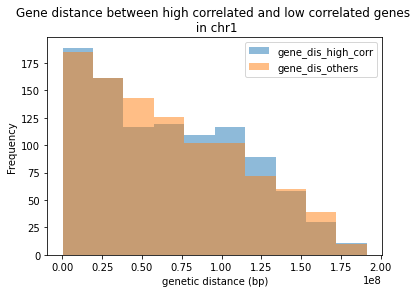

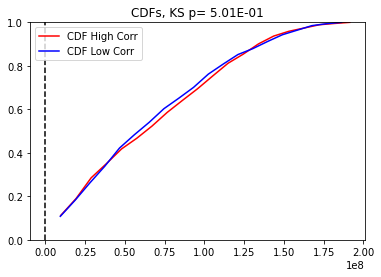

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1715.45it/s]


<Figure size 432x288 with 0 Axes>

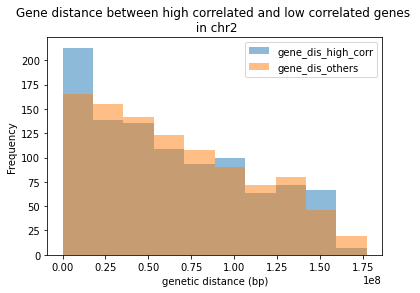

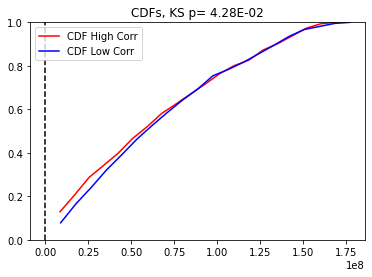

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1995.01it/s]


<Figure size 432x288 with 0 Axes>

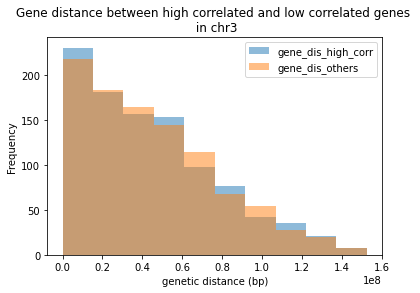

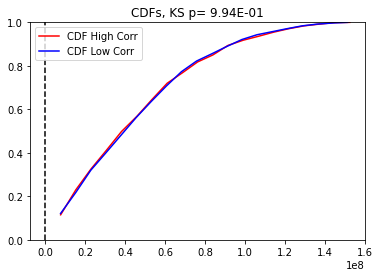

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1960.45it/s]


<Figure size 432x288 with 0 Axes>

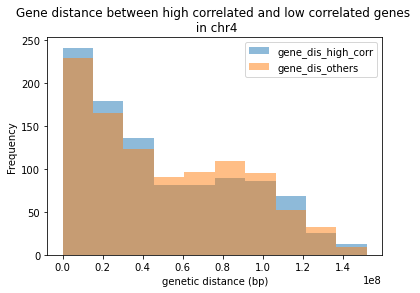

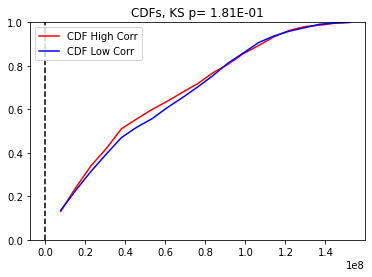

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1750.84it/s]


<Figure size 432x288 with 0 Axes>

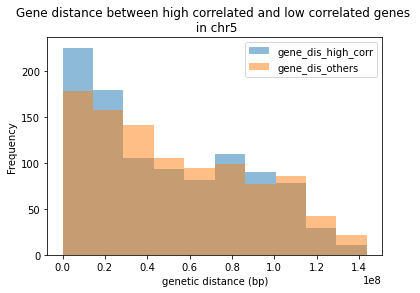

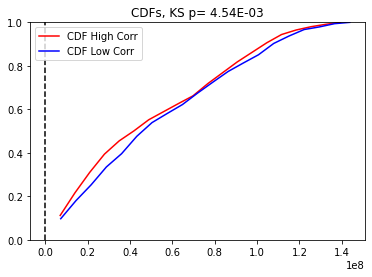

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1983.94it/s]


<Figure size 432x288 with 0 Axes>

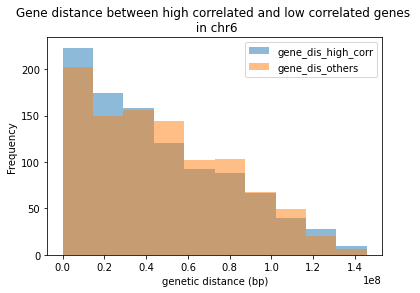

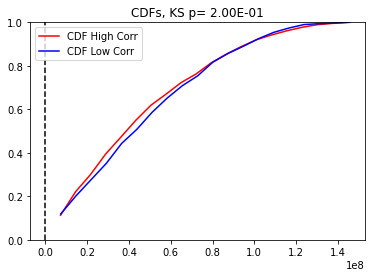

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1638.94it/s]


<Figure size 432x288 with 0 Axes>

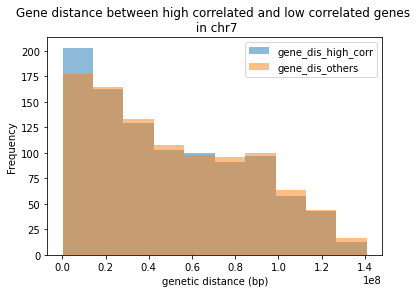

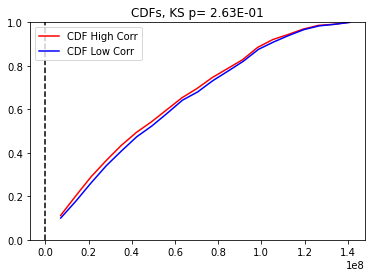

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2086.69it/s]


<Figure size 432x288 with 0 Axes>

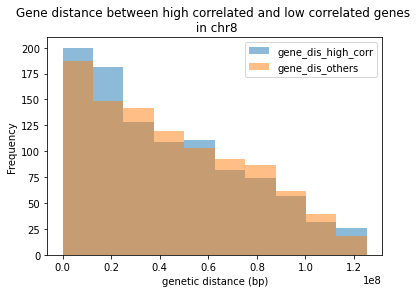

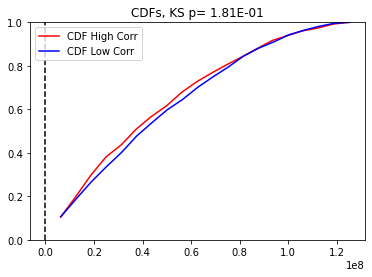

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1934.80it/s]


<Figure size 432x288 with 0 Axes>

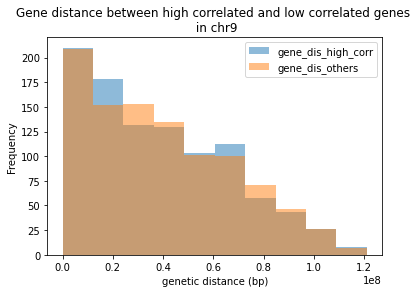

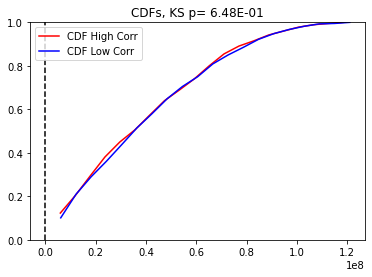

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2000.01it/s]


<Figure size 432x288 with 0 Axes>

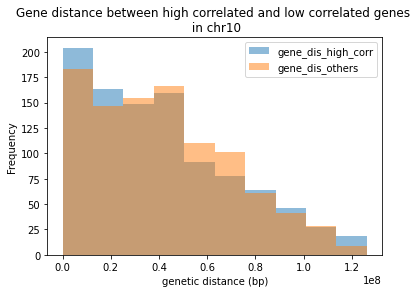

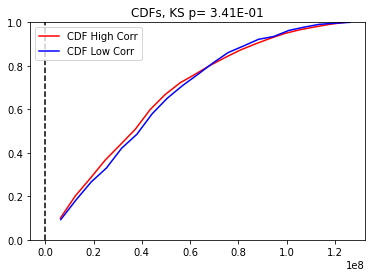

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1872.88it/s]


<Figure size 432x288 with 0 Axes>

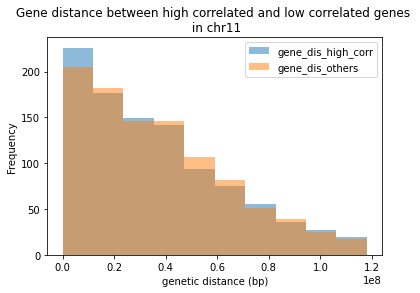

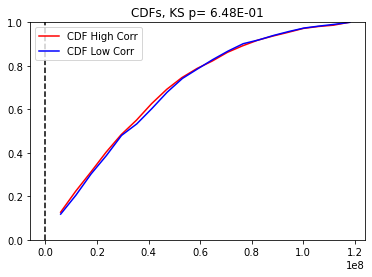

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2251.29it/s]


<Figure size 432x288 with 0 Axes>

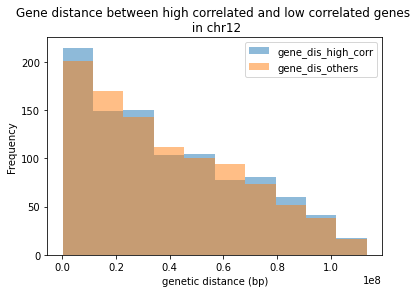

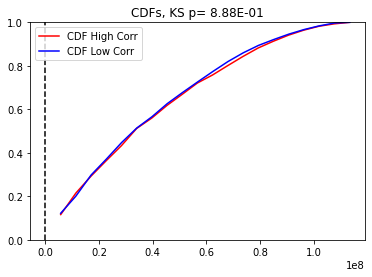

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2204.64it/s]


<Figure size 432x288 with 0 Axes>

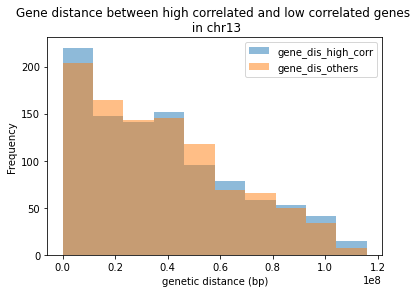

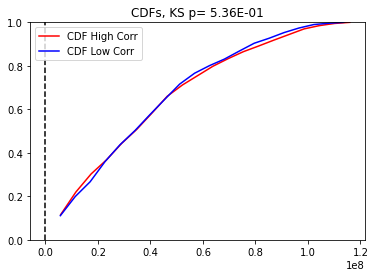

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2246.20it/s]


<Figure size 432x288 with 0 Axes>

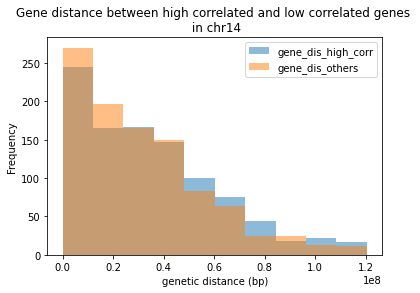

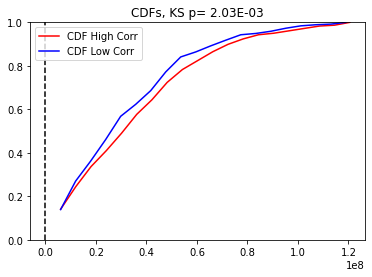

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2316.25it/s]


<Figure size 432x288 with 0 Axes>

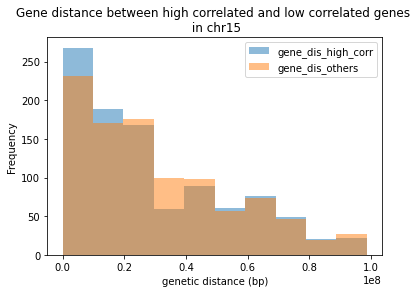

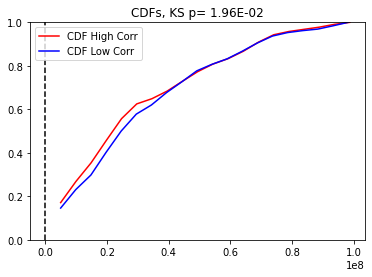

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2523.29it/s]


<Figure size 432x288 with 0 Axes>

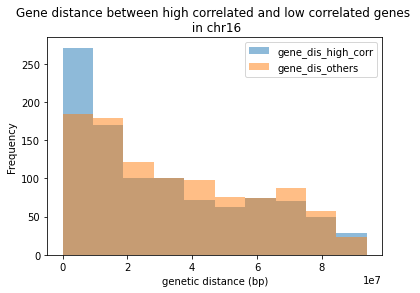

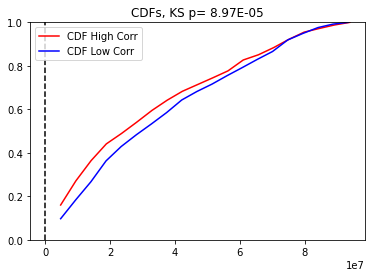

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2135.45it/s]


<Figure size 432x288 with 0 Axes>

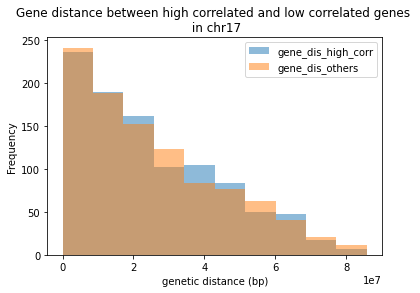

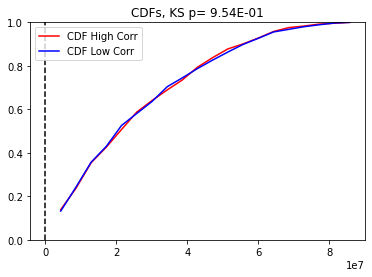

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2581.04it/s]


<Figure size 432x288 with 0 Axes>

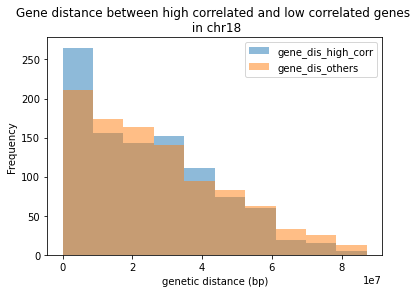

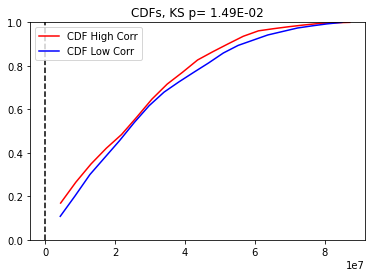

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2623.45it/s]


<Figure size 432x288 with 0 Axes>

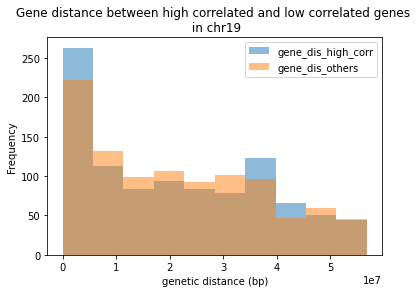

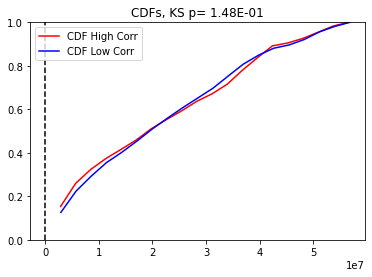

In [22]:
chromosome_list = ['chr'+str(i+1) for i in range(19)]
for chromosome in chromosome_list:
    tpm, gene_loc, tad = get_genes_from_chromosome(chromosome,norm_tpm,tad_data,gene_loc_data)
    all_genes_corr_df = tpm.transpose().corr()
    analysis3_high_corr_df, analysis3_other_corr_df = corr_vs_dist(all_genes_corr_df, gene_loc_data, plot=True, title = f"Gene distance between high correlated and low correlated genes \n in {chromosome}", save=f"../results/corr_vs_dist_plot_{chromosome}.png")
    analysis3_high_corr_df.to_csv(f"../results/analysis3_{chromosome}_high_corr_df.csv")
    analysis3_other_corr_df.to_csv(f"../results/analysis3_{chromosome}_other_corr_df.csv")
    #print(f"Analysis 3 done.")

__BAR__

In [ ]:
idxs = [idx for idx in range(len(gene_loc_data)) if not gene_loc_data.iloc[idx]['gene_name'].startswith("Gm") and not gene_loc_data.iloc[idx]['gene_name'].endswith("Rik")]


In [ ]:
ann_gloc = gene_loc_data.iloc[idxs]

In [ ]:
ann_gloc

In [ ]:
ann_gloc[ann_gloc['seqname']=='chr6']

In [ ]:
l = ['098537','000938','038227','038203','102373','099229','099173','099270','099248','038210','086427','101298','098683','098435']
genes = ['ENSMUSG00000'+i for i in l]

g_idxs = [g for g in genes if g in list(ann_gloc.index)]

ann_gloc.loc[g_idxs]

In [ ]:
l2 = ['099068','101451','038236','043219','087658','085696','079560','098536','056468','098749','087626','014704','029844','056445','000942','038253']
genes2 = ['ENSMUSG00000'+i for i in l2]

g_idxs2 = [g for g in genes2 if g in list(ann_gloc.index)]

ann_gloc.loc[g_idxs2]
